# DIVAnd full analysis

This notebook presents the different steps necessary for the creation of a climatology:
1. ODV data reading.
2. Extraction of bathymetry and creation of mask
3. Data download from other sources and duplicate removal.
4. Quality control.
5. Parameter optimisation.
6. Spatio-temporal interpolation with `DIVAnd`.

In [1]:
using Pkg
Pkg.status()

Status `C:\Users\jmbeckers\Documents\GitHub\Diva-Workshops\Project.toml`
  [336ed68f] CSV
  [34da2185] Compat
  [efc8151c] DIVAnd
  [864edb3b] DataStructures
  [7073ff75] IJulia
  [a98d9a8b] Interpolations
  [23992714] MAT
  [e1d29d7a] Missings
  [85f8d34a] NCDatasets
  [3725be50] PhysOcean
  [d330b81b] PyPlot
  [ade2ca70] Dates
  [8bb1440f] DelimitedFiles
  [37e2e46d] LinearAlgebra
  [56ddb016] Logging
  [44cfe95a] Pkg
  [de0858da] Printf
  [9a3f8284] Random
  [10745b16] Statistics
  [8dfed614] Test


### Import packages

In [2]:
using NCDatasets
using DataStructures
using DIVAnd
using Dates
using Statistics
using Random
using Printf
using PyPlot
using Interpolations

## Configuration
* Define the horizontal, vertical (depth levels) and temporal resolutions.
* Select the variable of interest

In [3]:
dx, dy = 0.125, 0.125
lonr = 11.5:dx:20
latr = 39:dy:46

depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];
depthr = depthr[1:20];

## 1. Read your ODV file
Adapt the `datadir` and `datafile` values.     
The example is based on a sub-setting of the [Mediterranean Sea](https://www.seadatanet.org/Products#/metadata/cd552057-b604-4004-b838-a4f73cc98fcf) aggregated dataset.      
The dataset has been extracted around the Adriatic Sea and exported to a netCDF using [Ocean Data View](https://odv.awi.de/).
<img src="./Images/MedSeaAggreg.jpg" width="450px">

In [4]:
datadir = "./Adriatic/"
smalldatafile = joinpath(datadir, "AdriaticSea_SDC_1000.nc")
datafile = joinpath(datadir, "AdriaticSea_SDC.nc")
isdir(datadir) ? @info("Directory already created") : mkpath(datadir)

[ Info: Directory already created


Download the data files (test and full) if needed.

In [5]:
if !isfile(smalldatafile)
    @info("Downloading test data file (1000 lines)")
    download("https://dox.ulg.ac.be/index.php/s/1CevuhrnDW18fJT/download", smalldatafile)
else
    @info("Small data file already downloaded")
end

if !isfile(datafile)
    @info("Downloading full data file")
    download("https://dox.ulg.ac.be/index.php/s/IRYJyNZ5KuKVoQL/download", datafile)
else
    @info("Full data file already downloaded")
end

[ Info: Small data file already downloaded
[ Info: Full data file already downloaded


You can try and test first on the small file, this should take less than 10 seconds (the 1st time).

In [6]:
@time obsval,obslon,obslat,obsdepth,obstime,obsid = NCODV.load(Float64, smalldatafile, 
    "Water body salinity");

  6.618640 seconds (7.48 M allocations: 396.149 MiB, 2.75% gc time, 99.36% compilation time)


Then you can read the full file:

In [7]:
@time obsval,obslon,obslat,obsdepth,obstime,obsid = NCODV.load(Float64, datafile, 
    "Water body salinity");

23160 out of 34709 - 66.72620934051687 %
  3.636354 seconds (634.02 k allocations: 192.559 MiB, 3.28% gc time)


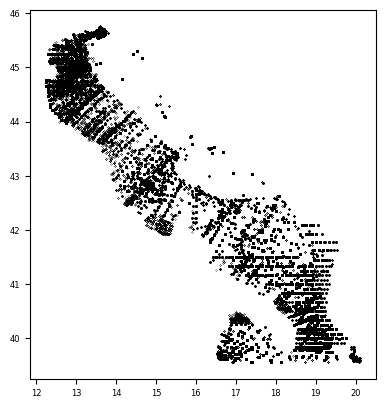

In [8]:
figure("Adriatic-Data")
ax = subplot(1,1,1)
plot(obslon, obslat, "ko", markersize=.1, markerfacecolor="k")
aspectratio = 1/cos(mean(latr) * pi/180)
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspectratio)

Check the extremal values of the observations

In [9]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

[ Info: Checking ranges for dimensions and observations


              minimum and maximum of obs. dimension 1: (12.25016975402832, 20.110000610351562)
              minimum and maximum of obs. dimension 2: (39.556758880615234, 45.755001068115234)
              minimum and maximum of obs. dimension 3: (0.0, 1484.2030029296875)
              minimum and maximum of obs. dimension 4: (DateTime("1911-08-17T09:24:00"), DateTime("2015-02-10T10:43:00"))
                          minimum and maximum of data: (4.070000171661377, 40.880001068115234)


## 2. Extract the bathymetry
It is used to delimit the domain where the interpolation is performed.

### 2.1 Choice of bathymetry
Modify `bathname` according to the resolution required.

In [10]:
bathname = "../data/gebco_30sec_8.nc"
isfile(bathname) ? @info("Bathymetry file already downloaded") : download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download", bathname)

[ Info: Bathymetry file already downloaded


In [11]:
@time bx,by,b = load_bath(bathname,true,lonr,latr);

  3.703333 seconds (6.68 M allocations: 346.143 MiB, 3.34% gc time, 99.50% compilation time)


sys:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


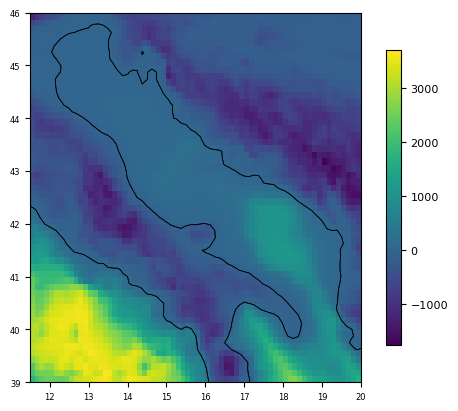

In [12]:
figure("Adriatic-Bathymetry")
ax = subplot(1,1,1)
pcolor(bx, by, permutedims(b, [2,1]));
colorbar(orientation="vertical", shrink=0.8).ax.tick_params(labelsize=8)
contour(bx, by, permutedims(b, [2,1]), [0, 0.1], colors="k", linewidths=.5)
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)

### 2.2 Create mask
* False for sea        
* True for land

In [13]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show size(mask)

size(mask) = (69, 57, 20)


(69, 57, 20)

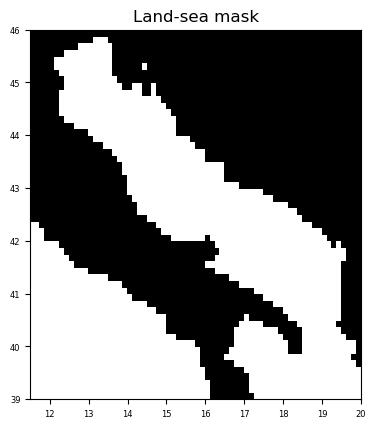

PyObject Text(0.5, 1.0, 'Land-sea mask')

In [14]:
figure("Adriatic-Mask")
ax = subplot(1,1,1)
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)
ax.pcolor(bx, by, transpose(mask[:,:,1]), cmap=PyPlot.cm.binary_r)
ax.set_title("Land-sea mask")

### 2.3 Edit the mask
As an example we will remove the Tyrrhenian Sea from the domain.

In [15]:
grid_bx = [i for i in bx, j in by];
grid_by = [j for i in bx, j in by];

In [16]:
mask_edit = copy(mask);
sel_mask1 = (grid_by .<= 42.6) .& (grid_bx .<= 14.);
sel_mask2 = (grid_by .<= 41.2) .& (grid_bx .<= 16.2);
mask_edit = mask_edit .* .!sel_mask1 .* .!sel_mask2;
@show size(mask_edit)

size(mask_edit) = (69, 57, 20)


(69, 57, 20)

In [17]:
sel = (obslon .<  maximum(bx)) .& (obslon .>  minimum(bx)) .& (obslat .<  maximum(by)) .& (obslat .>  minimum(bx))
obslon=obslon[sel]
obslat=obslat[sel]
obsdepth=obsdepth[sel]
obsval=obsval[sel]

1429996-element Vector{Float64}:
 38.108001708984375
 38.130001068115234
 38.15299987792969
 38.52399826049805
 38.66999816894531
 38.79800033569336
 38.82699966430664
 38.78099822998047
 38.69599914550781
 38.75600051879883
 38.821998596191406
 38.17900085449219
 38.17900085449219
  ⋮
 38.82699966430664
 38.8307991027832
 38.76179885864258
 38.806800842285156
 38.77949905395508
 38.72159957885742
 38.19020080566406
 38.19430160522461
 38.1870002746582
 38.17940139770508
 38.17340087890625
 38.17369842529297

The edited mask now looks like this:

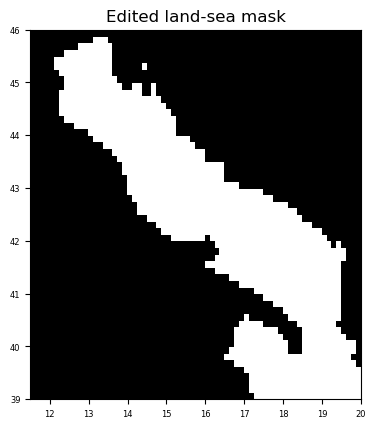

In [18]:
figure("Adriatic-Mask-Edited")
ax = subplot(1,1,1)
ax.tick_params("both",labelsize=6)
ax.pcolor(bx, by, mask_edit[:,:,1]', cmap=cmap=PyPlot.cm.binary_r)
ax.set_title("Edited land-sea mask")
gca().set_aspect(aspectratio)

## 6. Coordinate change

## 7. Analysis

In [19]:
xc,yc,zc=ndgrid(lonr,latr,depthr)
pmc = ones(size(xc)) / (xc[2,1,1]-xc[1,1,1]);
pnc = ones(size(xc)) / (yc[1,2,1]-yc[1,1,1]);
poc = ones(size(xc)) / (zc[1,1,2]-zc[1,1,1]);


In [20]:
sz = (length(lonr),length(latr),length(depthr));
lenx = fill(1.5,sz)  
leny = fill(1.0,sz)
lenz = fill(25.,sz);

epsilon2 = 0.1;
#epsilon2 = epsilon2 * rdiag;

In [21]:
obsmean=mean(obsval)

fi,s=DIVAndrun(mask,(pmc,pnc,poc),(xc,yc,zc),(obslon,obslat,obsdepth),obsval.-obsmean,(lenx,leny,lenz),epsilon2);

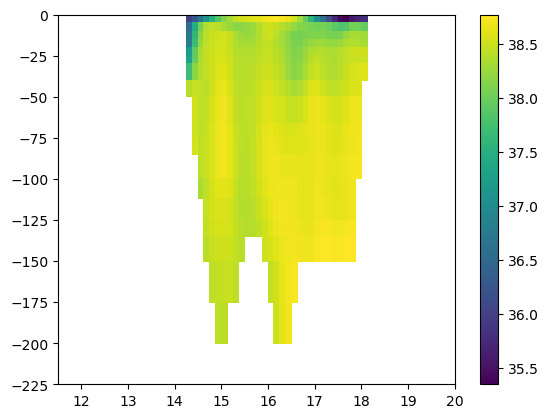

(PyObject <matplotlib.collections.PolyCollection object at 0x0000015B9B884FA0>, PyObject <matplotlib.colorbar.Colorbar object at 0x0000015B9B8FD400>)

In [22]:
jcut=30
pcolor(xc[:,jcut,:],-zc[:,jcut,:],fi[:,jcut,:].+obsmean),colorbar()

In [33]:

bfun=LinearInterpolation((bx,by),b)

function ztosigma(x,y,z)
    return z/max(2.0,bfun(x,y))
end
function sigmatoz(x,y,sigma)
    return sigma*max(2.0,bfun(x,y))
end

sigmatoz (generic function with 1 method)

In [34]:
bfun(16.,43.)

49.66601562155451

In [35]:
obssigma=ztosigma.(obslon,obslat,obsdepth)

1429996-element Vector{Float64}:
 0.0
 0.02631143258484212
 0.05262286516968424
 0.07893429775452636
 0.1315571629242106
 0.1973357443863159
 0.2631143258484212
 0.5262286516968424
 0.657785814621053
 0.7893429775452636
 1.0524573033936848
 0.0
 0.013385214818625323
 ⋮
 0.0018426883288136257
 0.0018426883288136257
 0.0018426883288136257
 0.0018426883288136257
 0.0018426883288136257
 0.0018426883288136257
 0.0018426883288136257
 0.0018426883288136257
 0.0018426883288136257
 0.0018426883288136257
 0.0018426883288136257
 0.0018426883288136257

In [36]:
xs,ys,sigma=ndgrid(lonr,latr,range(0;stop=1,length=size(depthr)[1]))
pms = ones(size(xc)) / (xs[2,1,1]-xs[1,1,1]);
pns = ones(size(xc)) / (ys[1,2,1]-ys[1,1,1]);
pos = ones(size(xc)) / (sigma[1,1,2]-sigma[1,1,1]);

masks=trues(size(mask))
masks[:,:,:].=mask[:,:,1]

lenx = fill(1.5,sz)  
leny = fill(1.0,sz)
lenz = fill(0.1,sz);

epsilon2 = 0.1;
#epsilon2 = epsilon2 * rdiag;
obsmean=mean(obsval)

fi,s=DIVAndrun(masks,(pms,pns,pos),(xs,ys,sigma),(obslon,obslat,obssigma),obsval.-obsmean,(lenx,leny,lenz),epsilon2);


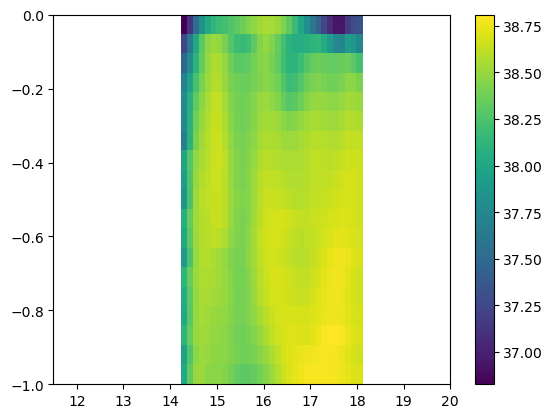

(PyObject <matplotlib.collections.PolyCollection object at 0x0000015B9BE6B520>, PyObject <matplotlib.colorbar.Colorbar object at 0x0000015B9BFA2370>)

In [37]:
jcut=30
pcolor(xs[:,jcut,:],-sigma[:,jcut,:],fi[:,jcut,:].+obsmean),colorbar()

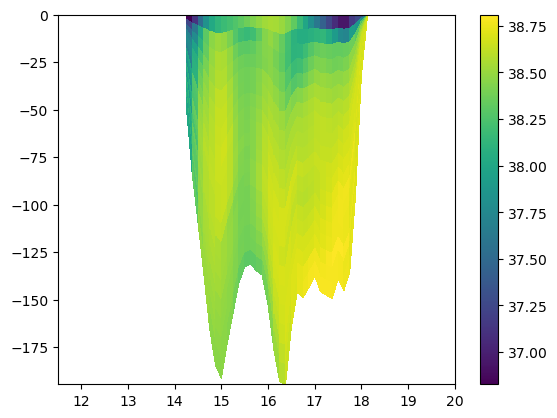

(PyObject <matplotlib.collections.PolyCollection object at 0x0000015BA733C160>, PyObject <matplotlib.colorbar.Colorbar object at 0x0000015BA73B3A90>)

In [38]:
zs=sigmatoz.(xs,ys,sigma)
#zs[zs.<0].=0.
jcut=30
pcolor(xs[:,jcut,:],-zs[:,jcut,:],fi[:,jcut,:].+obsmean),colorbar()

## Now exploiting directly non-uniform grids by creating the pmn etc

In [41]:
# We already have the z positions of the sigma layers we want to work with from above
# So now just recalculate the metrics:
pozc=deepcopy(pos)
for i = 1:sz[3]
        i0 = max(i - 1, 1)
        i1 = min(i + 1, sz[3])
        pozc[:,:,i].=(i1-i0)./(zs[:,:,i1].-zs[:,:,i0])
end

In [42]:
pozc[.!isfinite.(pozc)].=1.E10
mean(pozc)

5.386767383116807

### Get fractional indexes by working in sigma space:

In [43]:
Igrid = localize_separable_grid((obslon,obslat,obssigma), masks, (xs,ys,sigma), falses(3))

3×1429996 Matrix{Float64}:
 57.928  57.928    57.928    57.928    …  61.8532   61.8532   61.8532
 12.864  12.864    12.864    12.864        9.81424   9.81424   9.81424
  1.0     1.49992   1.99983   2.49975      1.03501   1.03501   1.03501

In [44]:
masks[:,:,:].=mask[:,:,1]

lenx = fill(1.5,sz)  
leny = fill(1.0,sz)
lenz = fill(25.0,sz);

epsilon2 = 0.1;
#epsilon2 = epsilon2 * rdiag;
obsmean=mean(obsval)

fi,s=DIVAndrun(masks,(pms,pns,pozc),(xs,ys,zs),(obslon,obslat,obsdepth),obsval.-obsmean,(lenx,leny,lenz),epsilon2;fracindex =Igrid);


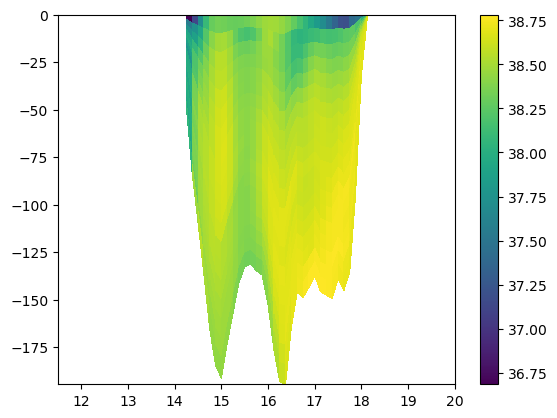

(PyObject <matplotlib.collections.PolyCollection object at 0x0000015BA7425730>, PyObject <matplotlib.colorbar.Colorbar object at 0x0000015BA77B9070>)

In [45]:


jcut=30
pcolor(xs[:,jcut,:],-zs[:,jcut,:],fi[:,jcut,:].+obsmean),colorbar()